In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns

In [117]:
imagen = plt.imread('Fotos/Ejemplo.tif')

imagen.shape

(270, 400, 3)

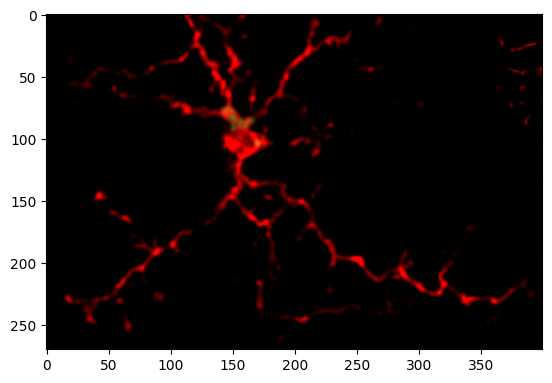

In [118]:
plt.imshow(imagen)

Ahora vamos a querer generar dos arrays nuevos usando el canal verde. Uno que tenga la información del canal verde donde el rojo sea positivo (canal_verde_sobre_rojo) y otro que tenga la información del canal verde donde el canal rojo sea negativo (canal_verde_anti_rojo)

In [119]:
#Creamos dos arrays nuevos, uno con el canal rojo y otro con el verde.
canal_rojo = imagen[:,:,0] #Canal rojo
canal_verde = imagen[:,:,1] #Canal verde

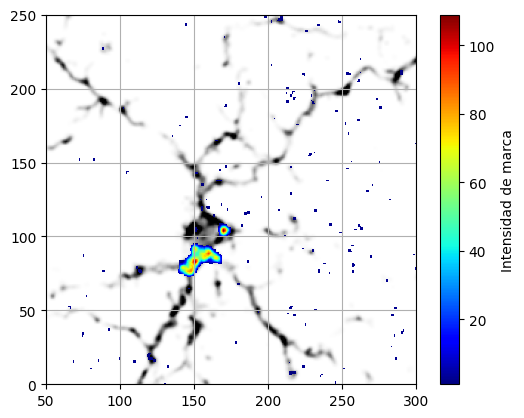

In [128]:
#Algo que podmos hacer, es plotear los dos canales por separado sobre el mismo plot
plt.imshow(canal_rojo, cmap='Greys')

# Creamos una máscara para el canal verde para que no se ploteen los valores menores a 5
mascara_verde = np.ma.masked_where(canal_verde <= 0, canal_verde)


plt.imshow(mascara_verde, cmap='jet')

#grilla
plt.grid(True)

plt.xlim(50, 300)
plt.ylim(0, 250)

# Add a colorbar
plt.colorbar( label='Intensidad de marca')


In [91]:
#Creo dos copias del canal verde para modificarlo
canal_verde_sobre_rojo = canal_verde.copy()
canal_verde_anti_rojo = canal_verde.copy()

#Usando la info del canal rojo, modifico el verde
canal_verde_sobre_rojo[canal_rojo == 0] = 0
canal_verde_anti_rojo[canal_rojo != 0] = 0

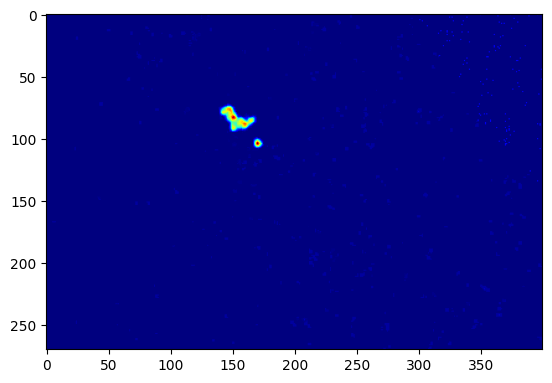

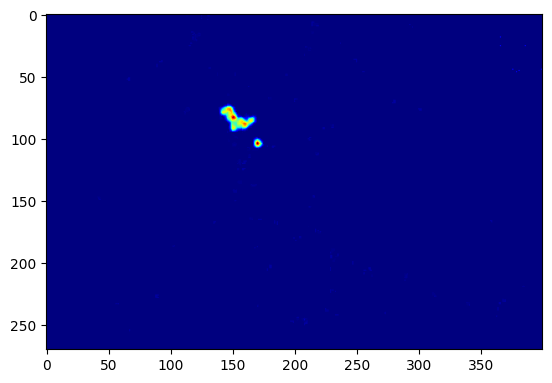

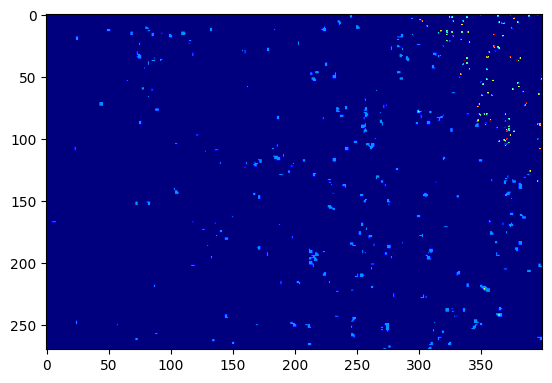

In [92]:
# cmaps en https://matplotlib.org/stable/users/explain/colors/colormaps.html


plt.imshow(canal_verde, cmap = 'jet')
plt.show()
plt.imshow(canal_verde_sobre_rojo, cmap = 'jet')
plt.show()
plt.imshow(canal_verde_anti_rojo, cmap = 'jet')
plt.show()



Cuantificación


Ahora vamos a querer cuantificar la señal en el canal verde en ambos arrays. Podemos hacerlos cuantificando el area positiva (cuantos pixels hay que son >0) o cuantificando la intensidad total por area (sumamos todos los pixels y lo dividimos por la cantidad de pixels >0)
Para hacerlo un poco más prolijo, primero vamos a hacer un par de funciones

In [93]:
def area_1_segun_2(canal1, canal2):
    '''Esta función recibe 2 arrays: canal1, canal2. Devuelve una tupla con dos valores, 
    el área (número de píxeles) del canal1 donde el canal2 es mayor a 0 y el área donde el canal2 es igual a 0.'''
    
    #Primero vamos a necesitar los lugares donde hay marca del canal 1
    # Máscara donde canal1 > 0
    mascara_sobre_1 = canal1 > 0
    
    #Ahora buscamos los lugares donde el canal 2 es positivo y donde es 0
    # Máscara donde canal2 > 0
    mascara_sobre_2 = canal2 > 0
    # Máscara donde canal2 == 0
    mascara_anti_2 = canal2 == 0

    # Ahora calculamos el área positiva para el canal 1 donde el canal 2 es positivo y donde es 0
    area_1_sobre_2 = np.sum(mascara_sobre_1 [mascara_sobre_2])
    area_1_anti_2 = np.sum(mascara_sobre_1 [mascara_anti_2])
    
    return (area_1_sobre_2, area_1_anti_2)

def intensidad_canal1_segun_area_canal2(canal1, canal2):
    '''Esta funcion recibe 2 arrays: canal1, canal2. Devuelve una tupla con dos valores,
    la intensidad media del canal1 donde el canal2 es mayor a 0 y la intensidad media del canal1 donde el canal2 es igual a 0.'''
    
    canal1_sobre_2 = canal1.copy()
    canal1_anti_2 = canal1.copy()
    
    canal1_sobre_2[canal2 == 0] = 0
    canal1_anti_2[canal2 != 0] = 0
    
    area_canal2 = np.sum(canal2 > 0)
    area_anti2 = np.sum(canal2 == 0)
    
    intensidad_1_sobre_2 = np.sum(canal1_sobre_2) / area_canal2
    intensidad_1_anti_2 = np.sum(canal1_anti_2) / area_anti2
    return (intensidad_1_sobre_2, intensidad_1_anti_2)


In [94]:
canal_verde.max()

109

In [95]:
#Probemos con la imagen de ejemplo
#contar pixels > 0 en canal verde
area_verde_total = np.sum(canal_verde > 0)
area_verde_sobre_rojo, area_verde_anti_rojo =  area_1_segun_2(canal_verde, canal_rojo)

print('Area verde total:', area_verde_total)
print('Area verde sobre rojo:', area_verde_sobre_rojo)
print('Area verde anti rojo:', area_verde_anti_rojo)

#Notar que el area roja (+) es mucho menor que el area roja (-). Estaría bueno normalizar esto.
area_roja_total = np.sum(canal_rojo > 0)
area_anti_rojo = np.sum(canal_rojo == 0)

area_verde_sobre_rojo_normalizada = area_verde_sobre_rojo / area_roja_total
area_verde_anti_rojo_normalizada = area_verde_anti_rojo / area_anti_rojo

print('Area verde sobre rojo normalizada:', area_verde_sobre_rojo_normalizada)
print('Area verde anti rojo normalizada:', area_verde_anti_rojo_normalizada)

intensidad_verde_sobre_rojo, intensidad_verde_anti_rojo = intensidad_canal1_segun_area_canal2(canal_verde, canal_rojo)
print('Intensidad meida por px verde sobre rojo:', intensidad_verde_sobre_rojo)
print('Intensidad meida por px verde anti rojo:', intensidad_verde_anti_rojo)

Area verde total: 2475
Area verde sobre rojo: 1063
Area verde anti rojo: 1412
Area verde sobre rojo normalizada: 0.058648275862068965
Area verde anti rojo normalizada: 0.015710709318497915
Intensidad meida por px verde sobre rojo: 1.080441379310345
Intensidad meida por px verde anti rojo: 0.05705702364394993


Creamos un dataframe para ir guardando lo que cuantifquemos de cada imagen

In [96]:
#Esto crea una dataframe vacío con las columnas que necesitamos. Cada fila va a ser la cuantificación de una imagen.
df = pd.DataFrame(columns = ['animal', 'groupo', 'foto' ,'Area_rel_Il1b_adentro', 
                             'Area_rel_Il1b_afuera', 'Intensidad_rel_Il1b_adentro', 'Intensidad_rel_Il1b_afuera'])

Con el siguiente bloque, vamos a cuantificar todas las fotos del primer animal:

In [97]:

###Estas 3 líneas cambian para cada animal:
mouse = 'Ctl_112'
group = "C"
Ubicacion = "Fotos/Ctl_112/*.tif" #Esto es la ubicación de las fotos para este animal en particular

### Esto es siempre lo mismo:
files = glob.glob(Ubicacion) #Esto nos da una lista con todas las fotos que están en la carpeta

for file in files:
    imagen = plt.imread(file)
    canal_rojo = imagen[:,:,0] #Canal rojo
    canal_verde = imagen[:,:,1] #Canal verde
    
    area_verde_total = np.sum(canal_verde > 0)
    area_verde_sobre_rojo, area_verde_anti_rojo =  area_1_segun_2(canal_verde, canal_rojo)
    
    area_roja_total = np.sum(canal_rojo > 0)
    area_anti_rojo = np.sum(canal_rojo == 0)

    area_verde_sobre_rojo_normalizada = area_verde_sobre_rojo / area_roja_total
    area_verde_anti_rojo_normalizada = area_verde_anti_rojo / area_anti_rojo

    intensidad_verde_sobre_rojo, intensidad_verde_anti_rojo = intensidad_canal1_segun_area_canal2(canal_verde, canal_rojo)
    
    new_row = pd.DataFrame({'animal': [mouse], 'groupo': [group], 'foto': [file], 'Area_rel_Il1b_adentro': [area_verde_sobre_rojo_normalizada],
                            'Area_rel_Il1b_afuera': [area_verde_anti_rojo_normalizada], 'Intensidad_rel_Il1b_adentro': [intensidad_verde_sobre_rojo],
                            'Intensidad_rel_Il1b_afuera': [intensidad_verde_anti_rojo]})
    df = pd.concat([df, new_row], ignore_index=True)

C:\Users\salva\AppData\Local\Temp\ipykernel_9256\1876908715.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [98]:
df.head()

,animal,groupo,foto,Area_rel_Il1b_adentro,Area_rel_Il1b_afuera,Intensidad_rel_Il1b_adentro,Intensidad_rel_Il1b_afuera
0,Ctl_112,C,Fotos/Ctl_112\1.tif,0.067243,0.015175,0.355277,0.076459
1,Ctl_112,C,Fotos/Ctl_112\2.tif,0.017655,0.003847,0.091954,0.024106
2,Ctl_112,C,Fotos/Ctl_112\3.tif,0.015144,0.001684,0.133589,0.008725
3,Ctl_112,C,Fotos/Ctl_112\4.tif,0.008543,0.000655,0.045942,0.003276


Ahora hacemos lo mismo para todas las carpetas: 
Qué hay que cambiar?

In [99]:
###Estas 3 líneas cambian para cada animal:
mouse = 'Ctl_253'
group = "C"
Ubicacion = "Fotos/Ctl_253/*.tif" #Esto es la ubicación de las fotos para este animal en particular

### Esto es siempre lo mismo:
files = glob.glob(Ubicacion) #Esto nos da una lista con todas las fotos que están en la carpeta

for file in files:
    imagen = plt.imread(file)
    canal_rojo = imagen[:,:,0] #Canal rojo
    canal_verde = imagen[:,:,1] #Canal verde
    
    area_verde_total = np.sum(canal_verde > 0)
    area_verde_sobre_rojo, area_verde_anti_rojo =  area_1_segun_2(canal_verde, canal_rojo)
    
    area_roja_total = np.sum(canal_rojo > 0)
    area_anti_rojo = np.sum(canal_rojo == 0)

    area_verde_sobre_rojo_normalizada = area_verde_sobre_rojo / area_roja_total
    area_verde_anti_rojo_normalizada = area_verde_anti_rojo / area_anti_rojo

    intensidad_verde_sobre_rojo, intensidad_verde_anti_rojo = intensidad_canal1_segun_area_canal2(canal_verde, canal_rojo)
    
    new_row = pd.DataFrame({'animal': [mouse], 'groupo': [group], 'foto': [file], 'Area_rel_Il1b_adentro': [area_verde_sobre_rojo_normalizada],
                            'Area_rel_Il1b_afuera': [area_verde_anti_rojo_normalizada], 'Intensidad_rel_Il1b_adentro': [intensidad_verde_sobre_rojo],
                            'Intensidad_rel_Il1b_afuera': [intensidad_verde_anti_rojo]})
    df = pd.concat([df, new_row], ignore_index=True)

Ahora para el Ctl_323:

In [100]:
###Estas 3 líneas cambian para cada animal:
mouse = 'Ctl_323'
group = "C"
Ubicacion = "Fotos/Ctl_323/*.tif" #Esto es la ubicación de las fotos para este animal en particular

### Esto es siempre lo mismo:
files = glob.glob(Ubicacion) #Esto nos da una lista con todas las fotos que están en la carpeta

for file in files:
    imagen = plt.imread(file)
    canal_rojo = imagen[:,:,0] #Canal rojo
    canal_verde = imagen[:,:,1] #Canal verde
    
    area_verde_total = np.sum(canal_verde > 0)
    area_verde_sobre_rojo, area_verde_anti_rojo =  area_1_segun_2(canal_verde, canal_rojo)
    
    area_roja_total = np.sum(canal_rojo > 0)
    area_anti_rojo = np.sum(canal_rojo == 0)

    area_verde_sobre_rojo_normalizada = area_verde_sobre_rojo / area_roja_total
    area_verde_anti_rojo_normalizada = area_verde_anti_rojo / area_anti_rojo

    intensidad_verde_sobre_rojo, intensidad_verde_anti_rojo = intensidad_canal1_segun_area_canal2(canal_verde, canal_rojo)
    
    new_row = pd.DataFrame({'animal': [mouse], 'groupo': [group], 'foto': [file], 'Area_rel_Il1b_adentro': [area_verde_sobre_rojo_normalizada],
                            'Area_rel_Il1b_afuera': [area_verde_anti_rojo_normalizada], 'Intensidad_rel_Il1b_adentro': [intensidad_verde_sobre_rojo],
                            'Intensidad_rel_Il1b_afuera': [intensidad_verde_anti_rojo]})
    df = pd.concat([df, new_row], ignore_index=True)

Ahora para SM_134 y ect...

In [101]:
###Estas 3 líneas cambian para cada animal:
mouse = 'SM_134'
group = "SM"
Ubicacion = "Fotos/SM_134/*.tif" #Esto es la ubicación de las fotos para este animal en particular

### Esto es siempre lo mismo:
files = glob.glob(Ubicacion) #Esto nos da una lista con todas las fotos que están en la carpeta

for file in files:
    imagen = plt.imread(file)
    canal_rojo = imagen[:,:,0] #Canal rojo
    canal_verde = imagen[:,:,1] #Canal verde
    
    area_verde_total = np.sum(canal_verde > 0)
    area_verde_sobre_rojo, area_verde_anti_rojo =  area_1_segun_2(canal_verde, canal_rojo)
    
    area_roja_total = np.sum(canal_rojo > 0)
    area_anti_rojo = np.sum(canal_rojo == 0)

    area_verde_sobre_rojo_normalizada = area_verde_sobre_rojo / area_roja_total
    area_verde_anti_rojo_normalizada = area_verde_anti_rojo / area_anti_rojo

    intensidad_verde_sobre_rojo, intensidad_verde_anti_rojo = intensidad_canal1_segun_area_canal2(canal_verde, canal_rojo)
    
    new_row = pd.DataFrame({'animal': [mouse], 'groupo': [group], 'foto': [file], 'Area_rel_Il1b_adentro': [area_verde_sobre_rojo_normalizada],
                            'Area_rel_Il1b_afuera': [area_verde_anti_rojo_normalizada], 'Intensidad_rel_Il1b_adentro': [intensidad_verde_sobre_rojo],
                            'Intensidad_rel_Il1b_afuera': [intensidad_verde_anti_rojo]})
    df = pd.concat([df, new_row], ignore_index=True)

In [102]:
###Estas 3 líneas cambian para cada animal:
mouse = 'SM_226'
group = "SM"
Ubicacion = "Fotos/SM_226/*.tif" #Esto es la ubicación de las fotos para este animal en particular

### Esto es siempre lo mismo:
files = glob.glob(Ubicacion) #Esto nos da una lista con todas las fotos que están en la carpeta

for file in files:
    imagen = plt.imread(file)
    canal_rojo = imagen[:,:,0] #Canal rojo
    canal_verde = imagen[:,:,1] #Canal verde
    
    area_verde_total = np.sum(canal_verde > 0)
    area_verde_sobre_rojo, area_verde_anti_rojo =  area_1_segun_2(canal_verde, canal_rojo)
    
    area_roja_total = np.sum(canal_rojo > 0)
    area_anti_rojo = np.sum(canal_rojo == 0)

    area_verde_sobre_rojo_normalizada = area_verde_sobre_rojo / area_roja_total
    area_verde_anti_rojo_normalizada = area_verde_anti_rojo / area_anti_rojo

    intensidad_verde_sobre_rojo, intensidad_verde_anti_rojo = intensidad_canal1_segun_area_canal2(canal_verde, canal_rojo)
    
    new_row = pd.DataFrame({'animal': [mouse], 'groupo': [group], 'foto': [file], 'Area_rel_Il1b_adentro': [area_verde_sobre_rojo_normalizada],
                            'Area_rel_Il1b_afuera': [area_verde_anti_rojo_normalizada], 'Intensidad_rel_Il1b_adentro': [intensidad_verde_sobre_rojo],
                            'Intensidad_rel_Il1b_afuera': [intensidad_verde_anti_rojo]})
    df = pd.concat([df, new_row], ignore_index=True)

In [103]:
###Estas 3 líneas cambian para cada animal:
mouse = 'SM_314'
group = "SM"
Ubicacion = "Fotos/SM_314/*.tif" #Esto es la ubicación de las fotos para este animal en particular

### Esto es siempre lo mismo:
files = glob.glob(Ubicacion) #Esto nos da una lista con todas las fotos que están en la carpeta

for file in files:
    imagen = plt.imread(file)
    canal_rojo = imagen[:,:,0] #Canal rojo
    canal_verde = imagen[:,:,1] #Canal verde
    
    area_verde_total = np.sum(canal_verde > 0)
    area_verde_sobre_rojo, area_verde_anti_rojo =  area_1_segun_2(canal_verde, canal_rojo)
    
    area_roja_total = np.sum(canal_rojo > 0)
    area_anti_rojo = np.sum(canal_rojo == 0)

    area_verde_sobre_rojo_normalizada = area_verde_sobre_rojo / area_roja_total
    area_verde_anti_rojo_normalizada = area_verde_anti_rojo / area_anti_rojo

    intensidad_verde_sobre_rojo, intensidad_verde_anti_rojo = intensidad_canal1_segun_area_canal2(canal_verde, canal_rojo)
    
    new_row = pd.DataFrame({'animal': [mouse], 'groupo': [group], 'foto': [file], 'Area_rel_Il1b_adentro': [area_verde_sobre_rojo_normalizada],
                            'Area_rel_Il1b_afuera': [area_verde_anti_rojo_normalizada], 'Intensidad_rel_Il1b_adentro': [intensidad_verde_sobre_rojo],
                            'Intensidad_rel_Il1b_afuera': [intensidad_verde_anti_rojo]})
    df = pd.concat([df, new_row], ignore_index=True)

Ahora ya tenemos las 6 carpetas cuantificadas.
Una aclaración, si tuvieramos muchísimas carpetas, podríamos hacer otro ciclo más para ir iterando automáticamente por cada una y ahorrarnos hacer tantos bloques de código. Acá lo hicimos así para que sea más fácil de entender.
Veamos el resultado final:

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in 

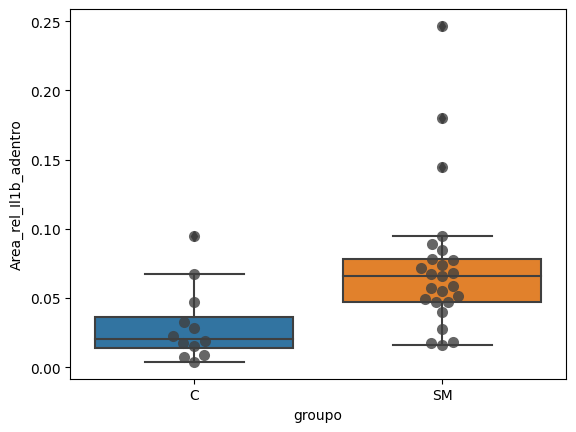

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in 

<Axes: xlabel='groupo', ylabel='Area_rel_Il1b_afuera'>

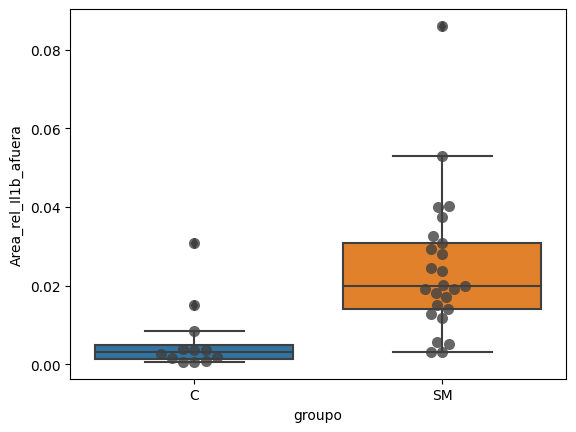

In [104]:
sns.swarmplot(x='groupo', y='Area_rel_Il1b_adentro', data=df, color=".25", alpha = 0.8,  size=8)
sns.boxplot(x='groupo', y='Area_rel_Il1b_adentro', data=df)

plt.show() #Si no ponemos esto, grafica todo en el mismo plot

sns.swarmplot(x='groupo', y='Area_rel_Il1b_afuera', data=df, color=".25", alpha = 0.8,  size=8)
sns.boxplot(x='groupo', y='Area_rel_Il1b_afuera', data=df)


C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in 

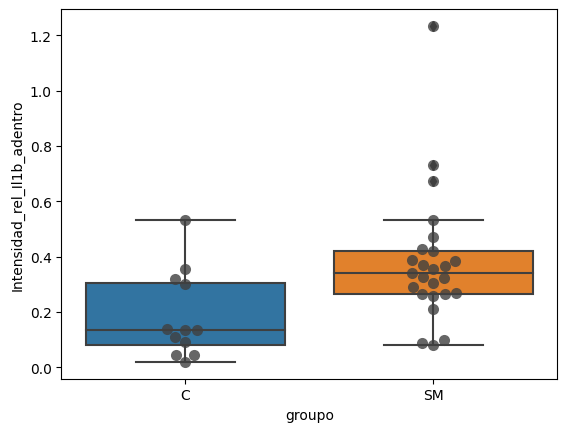

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in 

<Axes: xlabel='groupo', ylabel='Intensidad_rel_Il1b_afuera'>

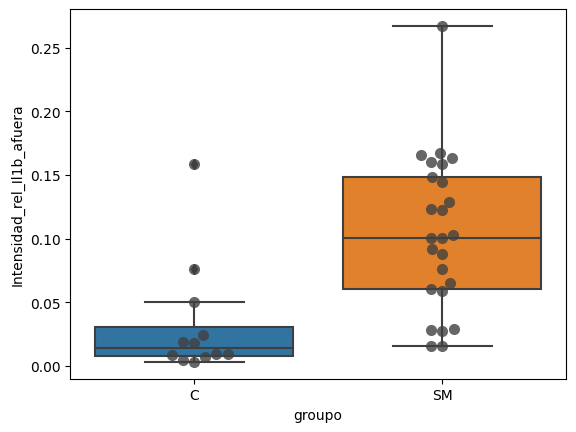

In [105]:
sns.swarmplot(x='groupo', y='Intensidad_rel_Il1b_adentro', data=df, color=".25", alpha = 0.8,  size=8)
sns.boxplot(x='groupo', y='Intensidad_rel_Il1b_adentro', data=df)

plt.show() #Si no ponemos esto, grafica todo en el mismo plot

sns.swarmplot(x='groupo', y='Intensidad_rel_Il1b_afuera', data=df, color=".25", alpha = 0.8,  size=8)
sns.boxplot(x='groupo', y='Intensidad_rel_Il1b_afuera', data=df)

In [106]:
#Por último, si queremos guardar el dataframe en un archivo .csv, podemos hacerlo con el siguiente comando:
df.to_csv('Resultados.csv', index = False)